In [1]:
!pip install textblob

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import re 
import pandas as pd
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
import csv
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
n_words= set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud,STOPWORDS
porter = PorterStemmer()

lemmatizer = WordNetLemmatizer() 
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:

def TwitterClient(): 
      # keys and tokens from the Twitter Dev Console 
      consumer_key = 'xxxxxxxx'
      consumer_secret ="xxxxxxxxxxx"
      access_token = 'xxxxxxxxxx'
      access_token_secret = 'xxxxxxxxxxx'

      # attempt authentication 
      try: 
          # create OAuthHandler object 
          auth = OAuthHandler(consumer_key, consumer_secret) 
          # set access token and secret 
          auth.set_access_token(access_token, access_token_secret) 
          # create tweepy API object to fetch tweets 
          api = tweepy.API(auth) 
      except: 
          print("Error: Authentication Failed") 

      return api

In [4]:
def clean(text):
  # removing @ tags and links from the text
  text= ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split()) 
  # converting all letters to lower case and relacing '-' with spaces.
  text= text.lower().replace('-', ' ')
  # removing stowards and numbers
  table= str.maketrans('', '', string.punctuation+string.digits)
  text= text.translate(table)
  # tokenizing words
  tokens = word_tokenize(text)
  # stemming the words 
  stemmed = [porter.stem(word) for word in tokens]
  words = [w for w in stemmed if not w in n_words]
  # lemmetizing words
  # lemme= [lemmatizer.lemmatize(word) for word in tokens]
  # words = [w for w in lemme if not w in n_words]
  text = ' '.join(words)
  return text 

In [5]:
  def get_tweets(query, count = 10): 
      ''' 
      Main function to fetch tweets and parse them. 
      '''
      # empty list to store parsed tweets 
      tweets = [] 

      try: 
          # call twitter api to fetch tweets 
          fetched_tweets = api.search(q = query, count = count) 
          for tweet in fetched_tweets:
            # cleaning the tweets
            tweet= clean(tweet.text)
            # getting the sentiment from textblob
            analysis = TextBlob(tweet)
            senti= analysis.sentiment.polarity
            # labeling the sentiment
            if senti<0 :
              emotion = "NEG"
            elif senti>0:
              emotion= "POS"
            else:
              emotion= "NEU"
            # appending all data
            tweets.append((tweet, senti, emotion))
            
          return tweets
      except tweepy.TweepError as e:
          # print error (if any) 
          print("Error : " + str(e)) 

In [6]:

# getting the api access
api = TwitterClient() 
# calling function to get tweets 
tweets = get_tweets(query = "Farmer's Protest", count = 200) 
# putting our collected data in pandas dataframe.
df= pd.DataFrame(tweets, columns= ['tweets', 'senti', 'emotion'])
# droping retweets
df= df.drop_duplicates()
# saving to CSV file
df.to_csv('data.csv', index= False)

In [7]:
# the below function will create a word cloud
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word  # double check for nay links
                                and not word.startswith('#')  # removing hash tags
                                and word != 'rt'  
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS, # using stopwords provided by Word cloud its optional since we already removed stopwords :)
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    # using matplotlib to display the images in notebook itself.
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
  

In [8]:
df_neu= df[ df['emotion'] == 'NEU']
df_neu= df_neu['tweets']
df_pos = df[ df['emotion'] == 'POS']
df_pos = df_pos['tweets']
df_neg = df[ df['emotion'] == 'NEG']
df_neg = df_neg['tweets']

In [9]:
ratio_pos= len(df_pos)/len(df)
ratio_neg= len(df_neg)/len(df)
ratio_neu= len(df_neu)/len(df)
print(f' Percentage Positive: {ratio_pos}\n Percentage Negetive: {ratio_neg}\n Percentage Neutral: {ratio_neu}')

 Percentage Positive: 0.18333333333333332
 Percentage Negetive: 0.1
 Percentage Neutral: 0.7166666666666667


Positive words


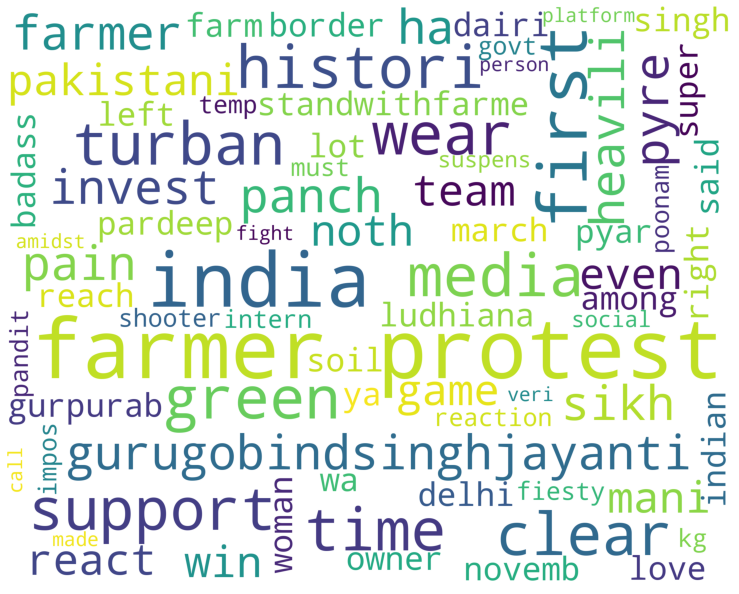

Negative words


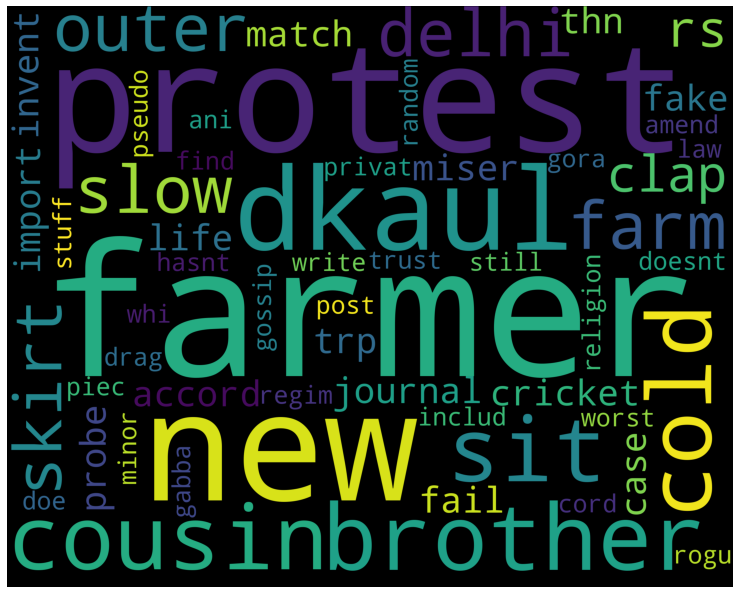

Neutral words


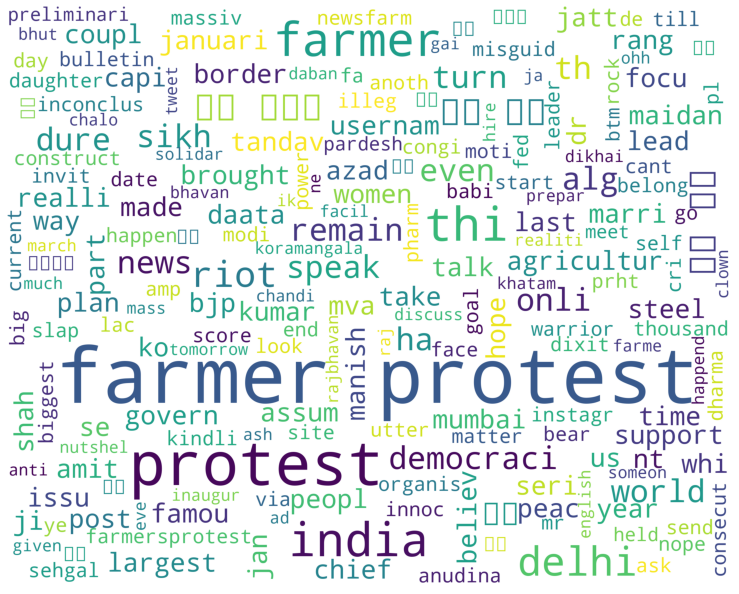

In [10]:
print("Positive words")
wordcloud_draw(df_pos, 'white')
print("Negative words")
wordcloud_draw(df_neg)
print("Neutral words")
wordcloud_draw(df_neu, 'white')